Car License Plate Reader - Overview
1. Input Image
2. Grayscale Image
3. Binarize Image
4. Plate Localization
5. Character Segmentation
6. Character Recognition

In [2]:
# Author: Luke O'Shea Scanlan, Panagiotis Bampilis
# Module: Image Processing 2023-2024
# Group Project

import cv2
import numpy as np
from matplotlib import pyplot as plt

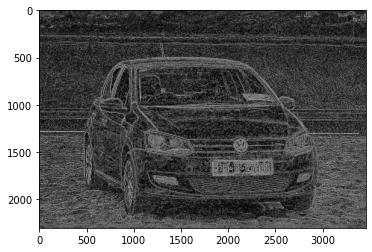

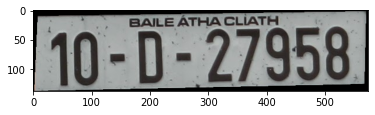

In [155]:
"""
This project aims to give the user the ability to input any sample images of car license plates
and return the results as a text output.

The product is capable of recognising car license plates rotated, as well as a certain amount of blurriness.

"""

# Input Image
# I = cv2.imread("Sample Inputs/gardai_cars.jpg")
I = cv2.imread("Sample Inputs/personal.jpg")
# I = cv2.imread("Sample Inputs/personal_two.jpg")

# HSV Image
# G = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
G = cv2.cvtColor(I, cv2.COLOR_BGR2HSV)[:,:,2]

# Binarize Image
# _, B = cv2.threshold(G, 140, 255, cv2.THRESH_BINARY)
B = cv2.adaptiveThreshold(G, maxValue = 255, adaptiveMethod = cv2.ADAPTIVE_THRESH_MEAN_C, thresholdType = cv2.THRESH_BINARY, blockSize = 3, C = 0)


# Plate Localization
blank = np.zeros_like(I)
cropping_coord = []
contours, hierarchy = cv2.findContours(image=B, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
image_copy = cv2.cvtColor(I.copy(), cv2.COLOR_BGR2RGB)

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # check 1 - No smaller than a standard plate 
    check_one = cv2.contourArea(contour) > (h*w/2)
    # check 2 - No larger than a standard plate
    check_two = cv2.contourArea(contour) < (h*w*2) 
    # check 4 - Too small to reliably extract text
    check_three = cv2.contourArea(contour) > 500
    # check 4 - Box found is sideways
    check_four = h < w
    
    total_checks = check_one and check_two and check_three and check_four
    
    if len(approx) == 4: 
        if (h*5.5) > w and (h*7) > w:
            if  total_checks:
                cv2.drawContours(blank, [approx], 0, (255, 255, 255), -1)
                cropping_coord.append((x, y, w, h))
                

# Plate Cropping
reg = cv2.bitwise_and(I, I, mask=cv2.cvtColor(blank, cv2.COLOR_BGR2GRAY))
x, y, w, h = cropping_coord[0]
CROP = reg[y:y+h,x:x+w]

fig, args = plt.subplots(1, 1)
args.imshow(B, cmap="gray")

image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
cv2.imwrite("temporary_image.jpg", CROP)

fig2, arg = plt.subplots(1, 1)
arg.imshow(CROP)